# Lab 5 - Ensembles 
Here is what we will do:
1. Create a data set with two input features and a 3 category target
2. Train a decision tree on the data set for a baseline
3. Train 3 ensemble models
    - Serial Ada Boosted DT
    - Decision Forest
    - Ensemble of DT, SVM, and NN
3. Get model performance on train and test sets
4. Create appropriate graphs
5. Do a 10 fold cross validation with 

### Prepare the data

### Settings for the generated dataset
This data set will be spirals with noise
arms - This is the number of categories we will have
turns - How many times we go around the spiral
width - How wide is the spiral (percentage of the radius)
noise - How much noise we will add to the data.
size - The number of points to generate

In [61]:
arms = 3
turns = 1.5
width = 0.3
noise = .25
size = 4000

### The spirals will be based on the equation r=theta

Build set
Arm 0
Using offset 0.0
Arm 1
Using offset 2.0943951023931953
Arm 2
Using offset 4.1887902047863905


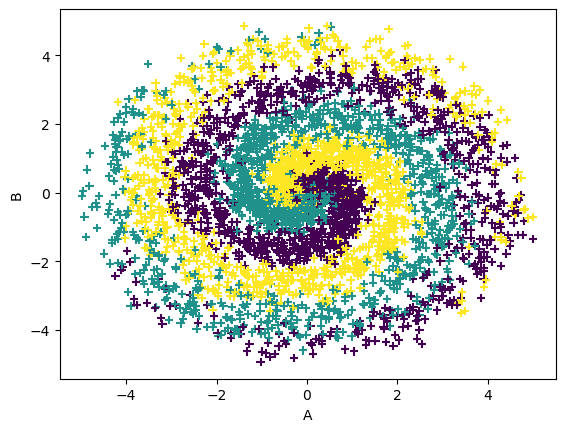

In [62]:
import numpy as np
import pandas as pd


def build_arm(n):
    print("Arm", n)
    points_per_arm = int(size/arms)
    #Get points on the curve
    theta_values = np.random.uniform(0, np.pi*turns, points_per_arm)
    r_values = theta_values
    target_values = [n] * points_per_arm
    
    #Add make the arm wider
    lower_fraction = (1 - width)*theta_values
    upper_fraction = (1 + width)*theta_values
    difference = upper_fraction - lower_fraction
    location = np.random.uniform(0, 1, points_per_arm)
    theta_values = theta_values + lower_fraction + difference*location
    
    #offset angle 
    offset = n*2*np.pi/arms
    print('Using offset', offset)
    theta_values = theta_values + offset
    
    #draw the noise from a distribution centered on 0.0 with a standard deviation of noise
    x_noise_values = np.random.normal(0, noise, points_per_arm)
    y_noise_values = np.random.normal(0, noise, points_per_arm)
    x_values = r_values * np.sin(theta_values) + x_noise_values
    y_values = r_values * np.cos(theta_values) + y_noise_values
    
    
    return x_values, y_values, target_values
    

def build_set():
    data_x = np.array([])
    data_y = np.array([])
    data_t = np.array([])
    print("Build set")
    for i in range(0,arms):
        x, y, t = build_arm(i)
        #print(data_x)
        #print(x)
        #print(y)
        #print(t)
        # add each arm to the data set
        data_x=np.append(data_x, x)
        data_y=np.append(data_y, y)
        data_t=np.append(data_t, t)
     # create a dictionary with each feature
    d = {}
    d["A"] = data_x
    d["B"] = data_y
    d["Class"] = data_t

    #print(d)

    # Create the data frame from the dictionary
    
    dataframe = pd.DataFrame(data=d)
    return dataframe
    

spiral = build_set()

import matplotlib.pyplot as plt

#shuffle before plotting so we don't always overwrite with the same color
shuffled = spiral.sample(frac=1)
plt.scatter(shuffled['A'], shuffled['B'], c=shuffled['Class'], marker='+')

plt.xlabel('A')
plt.ylabel('B')
plt.show()
    




### Stratified Test/Train Data Split

In [63]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_indices, test_indices in splitter.split(spiral, spiral['Class']):
    train_set = spiral.iloc[train_indices]
    test_set = spiral.iloc[test_indices]
    



### A Helpful plotting function for showing true and false for the categories

In [64]:
import matplotlib.pyplot as plt

def plot2FeatureBinaryConfusion(data_set, feature1Label, feature2Label, targetLabel, predicted, positive=1, negative=0):
## assumes that the target is 0/1

    
    target = data_set[targetLabel]
    
    # Filter with feature 1
    feature1_positives = np.ma.masked_where(target==negative, 
                     data_set[feature1Label])
    true_positive = np.ma.masked_where(predicted!=target, feature1_positives)
    false_negative = np.ma.masked_where(predicted==target, feature1_positives)
    feature1_negatives = np.ma.masked_where(target==positive, 
                     data_set[feature1Label])
    true_negative = np.ma.masked_where(predicted!=target, feature1_negatives)
    false_positive = np.ma.masked_where(predicted==target,feature1_negatives)

   
    feature2 = data_set[feature2Label]
    plt.scatter(true_positive, feature2, c='green', marker='o')
    plt.scatter(false_positive, feature2, c='red', marker='^')
    plt.scatter(true_negative, feature2, c='blue', marker='o')
    plt.scatter(false_negative, feature2, c='orange', marker='^')



    plt.xlabel(feature1Label)
    plt.ylabel(feature2Label)
    plt.legend(['True Positive', 'False Positive', 'True Negative', 'False Negative'])
    plt.show()

### Train and evaluate Decision Tree model 

In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

tree_model = DecisionTreeClassifier()
tree_model.fit(X,y)

y_pred = tree_model.predict(X)
print('Results for decision tree on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = tree_model.predict(X_test)
print('Results for decision tree on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))



Results for decision tree on training data
  Default settings
Confusion Matrix
[[1067    0    0]
 [   0 1066    0]
 [   0    0 1066]]
Accuracy is   1.0
Precision is  1.0
Recall is     1.0
F1 is         1.0

Results for decision tree on test data
  Default settings
Confusion Matrix
[[193  35  38]
 [ 30 202  35]
 [ 34  31 202]]
Accuracy is   0.74625
Precision is  0.7464108248552076
Recall is     0.74625
F1 is         0.7462026297505162


### Train and evaluate SVC model 

In [66]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

svc_model = SVC()
svc_model.fit(X,y)

y_pred = svc_model.predict(X)
print('Results for svc on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = svc_model.predict(X_test)
print('Results for svc on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))



Results for svc on training data
  Default settings
Confusion Matrix
[[797 131 139]
 [181 763 122]
 [157 156 753]]
Accuracy is   0.7230384495154736
Precision is  0.7238175278356889
Recall is     0.7230384495154736
F1 is         0.7230328869733087

Results for svc on test data
  Default settings
Confusion Matrix
[[203  33  30]
 [ 38 188  41]
 [ 43  36 188]]
Accuracy is   0.72375
Precision is  0.7240699096514094
Recall is     0.72375
F1 is         0.723504331856574


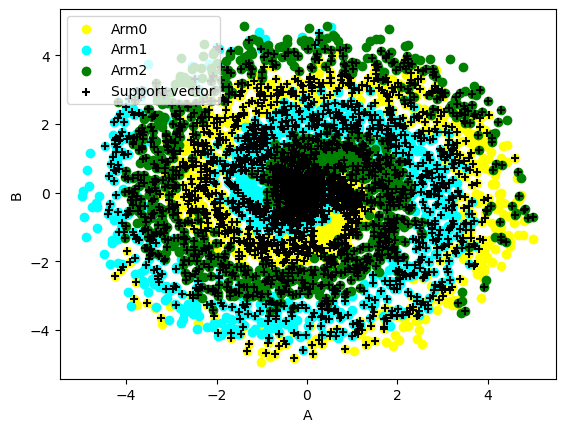

In [67]:
import matplotlib.pyplot as plt
arm0_A = np.ma.masked_where(spiral['Class']!=0, 
                     spiral['A'])

arm1_A = np.ma.masked_where(spiral['Class']!=1, 
                     spiral['A'])

arm2_A = np.ma.masked_where(spiral['Class']!=2, 
                     spiral['A'])



# get the values for the support vectors (the special instances)
support_x = [x for (x,y) in svc_model.support_vectors_]
support_y = [y for (x,y) in svc_model.support_vectors_]




b = spiral['B']
plt.scatter(arm0_A, b, c='yellow', marker='o')
plt.scatter(arm1_A, b, c='cyan', marker='o')
plt.scatter(arm2_A, b, c='green', marker='o')
plt.scatter(support_x, support_y, c='black', marker='+')

plt.xlabel('A')
plt.ylabel('B')
plt.legend(['Arm0', 'Arm1', 'Arm2','Support vector'])
plt.show()

### Train and evaluate Neural Net model 

In [68]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

nn_model = MLPClassifier(hidden_layer_sizes=(50, 25, 10),
                         solver='lbfgs')
nn_model.fit(X,y)

y_pred = nn_model.predict(X)


print('Results for NN on train data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = nn_model.predict(X_test)
print('Results for NN on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))




Results for NN on train data
  Default settings
Confusion Matrix
[[891  88  88]
 [ 88 885  93]
 [ 95  75 896]]
Accuracy is   0.8352610190684588
Precision is  0.8353365966793224
Recall is     0.8352610190684588
F1 is         0.8352682691476053

Results for NN on test data
  Default settings
Confusion Matrix
[[221  22  23]
 [ 26 208  33]
 [ 27  14 226]]
Accuracy is   0.81875
Precision is  0.8201659075459736
Recall is     0.81875
F1 is         0.8186413722037459


C:\Users\jorda\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### Train and evaluate ADA boosted model 

In [69]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

ada_model = AdaBoostClassifier(n_estimators=150)
ada_model.fit(X,y)

y_pred = ada_model.predict(X)


print('Results for ADA on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = ada_model.predict(X_test)
print('Results for ADA on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))




Results for ADA on training data
  Default settings
Confusion Matrix
[[662 201 204]
 [167 727 172]
 [172 175 719]]
Accuracy is   0.6589559237261644
Precision is  0.6590244502957131
Recall is     0.6589559237261644
F1 is         0.6586674955660985

Results for ADA on test data
  Default settings
Confusion Matrix
[[148  65  53]
 [ 30 188  49]
 [ 52  47 168]]
Accuracy is   0.63
Precision is  0.6307731884057971
Recall is     0.63
F1 is         0.6285769863200481


In [70]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

ada_model = AdaBoostClassifier(n_estimators=150)
ada_model.fit(X,y)

y_pred = ada_model.predict(X)


print('Results for ADA on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = ada_model.predict(X_test)
print('Results for ADA on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))




Results for ADA on training data
  Default settings
Confusion Matrix
[[662 201 204]
 [167 727 172]
 [172 175 719]]
Accuracy is   0.6589559237261644
Precision is  0.6590244502957131
Recall is     0.6589559237261644
F1 is         0.6586674955660985

Results for ADA on test data
  Default settings
Confusion Matrix
[[148  65  53]
 [ 30 188  49]
 [ 52  47 168]]
Accuracy is   0.63
Precision is  0.6307731884057971
Recall is     0.63
F1 is         0.6285769863200481


### Train and evaluate Random Forest model 

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

rf_model = RandomForestClassifier(n_estimators=150)
rf.fit(X,y)

y_pred = rf.predict(X)


print('Results for Random Forest on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = rf.predict(X_test)
print('Results for Random Forest on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))




Results for Random Forest on training data
  Default settings
Confusion Matrix
[[1067    0    0]
 [   0 1066    0]
 [   0    0 1066]]
Accuracy is   1.0
Precision is  1.0
Recall is     1.0
F1 is         1.0

Results for Random Forest on test data
  Default settings
Confusion Matrix
[[212  30  24]
 [ 23 209  35]
 [ 28  20 219]]
Accuracy is   0.8
Precision is  0.8002604772253369
Recall is     0.8
F1 is         0.7999509902113725


### Train and evaluate Voting model 
We build it out of three different kinds of classifiers
One each of DT, SVC, and NN

In [72]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Build the classifiers
vcl_dt = DecisionTreeClassifier()
vc2_svm = SVC()
vc3_nn = MLPClassifier(hidden_layer_sizes=(50, 25, 10),
                       solver='lbfgs')

# Bundle into a list with names
vcList = [('DT', vcl_dt),          ('SVM', vc2_svm),          ('NN', vc3_nn)]

vc_model = VotingClassifier(vcList)

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

voting_model = VotingClassifier(estimators=vcList)
voting_model.fit(X,y)

y_pred = voting_model.predict(X)


print('Results for Voting Ensemble on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = voting_model.predict(X_test)
print('Results for Voting Ensemble on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))


C:\Users\jorda\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Results for Voting Ensemble on training data
  Default settings
Confusion Matrix
[[962  67  38]
 [ 77 920  69]
 [ 87  53 926]]
Accuracy is   0.8777743044701469
Precision is  0.8784542203891472
Recall is     0.8777743044701469
F1 is         0.8777852281548081

Results for Voting Ensemble on test data
  Default settings
Confusion Matrix
[[223  26  17]
 [ 29 207  31]
 [ 36  23 208]]
Accuracy is   0.7975
Precision is  0.7984966362847223
Recall is     0.7975
F1 is         0.7973411172698469


### Cross Validate a Decision Tree Model

In [73]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

accuracy_list = np.array([])
f1_list = np.array([])

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
for train_indices, validate_indices in splitter.split(spiral,
                                                     spiral['Class']):
    train_set = spiral.iloc[train_indices]
    validate_set = spiral.iloc[validate_indices]
    X = train_set[['A','B' ]]
    y = train_set['Class']
    X_validate = validate_set[['A','B']]
    y_validate = validate_set['Class']
    
    model = DecisionTreeClassifier()
    model.fit(X,y)
    y_validate_pred = model.predict(X_validate)
    accuracy = accuracy_score(y_validate, y_validate_pred)

    print("Confusion Matrix")
    print(confusion_matrix(y_validate, y_validate_pred))
    print('Accuracy is ', accuracy)

    accuracy_list = np.insert(accuracy_list, 0, accuracy)

print("Accuracy values", accuracy_list)
print("Average of ", np.average(accuracy_list))
print("StDev of ", np.std(accuracy_list))


Confusion Matrix
[[101  17  16]
 [ 16 101  16]
 [ 13  14 106]]
Accuracy is  0.77
Confusion Matrix
[[104   6  24]
 [ 16 104  13]
 [ 19  22  92]]
Accuracy is  0.75
Confusion Matrix
[[ 90  28  16]
 [ 16 100  17]
 [ 14  14 105]]
Accuracy is  0.7375
Confusion Matrix
[[107  17   9]
 [ 18  98  18]
 [ 21  16  96]]
Accuracy is  0.7525
Confusion Matrix
[[ 98  16  19]
 [ 14 106  14]
 [ 17  10 106]]
Accuracy is  0.775
Confusion Matrix
[[ 97  14  22]
 [ 21 102  11]
 [ 18  22  93]]
Accuracy is  0.73
Confusion Matrix
[[ 96  16  21]
 [ 13 107  13]
 [ 18  19  97]]
Accuracy is  0.75
Confusion Matrix
[[ 98  17  18]
 [ 20  94  19]
 [ 14  15 105]]
Accuracy is  0.7425
Confusion Matrix
[[110  13  10]
 [  8 102  23]
 [ 17  15 102]]
Accuracy is  0.785
Confusion Matrix
[[107  15  11]
 [ 22 103   8]
 [ 19  12 102]]
Accuracy is  0.7819548872180451
Accuracy values [0.78195489 0.785      0.7425     0.75       0.73       0.775
 0.7525     0.7375     0.75       0.77      ]
Average of  0.7574454887218046
StDev of  0.0

# Results
Basic results for our classification model to predict arm on the spiral data set

| Model | Training Features | Acc Train | F1 Train |Acc Test | F1 Test |
|:---|:---|:---|:---|:---|:---|
|Decision Tree|A,B|100.0|100.0|71.62 | 71.63 |
|SVC|A,B|71.58|71.58|70.5|70.42|
|MLP|A,B layers (50,25,10) lbfgs|80.06|80.13|77.87|77.91
|ADA|A,B 150 estimators|65.46|65.48|65.46|60.46|
|RF|A,B 150 estimators|1|1|1|1|
|VC|A,B|89.53|89.54|89.53|89.53|
